# Classifying Breast Cancer
## Breast Cancer Wisconsin (Diagnostic) Data Set

From: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/

References:
- [Diagnosing breast cancer with AI // Coding for Medicine #3](https://www.youtube.com/watch?v=c8s5GKRrenY&t=1482s)
- [A Gentle Introduction to tidymodels](https://rviews.rstudio.com/2019/06/19/a-gentle-intro-to-tidymodels/)'
- [Blog Post 4 - An Introduction To Tidymodels](https://rstudio-pubs-static.s3.amazonaws.com/606415_29e3fe510fd94f9da60b19e2abf07397.html)
- [Get started with tidymodels and classification of penguin data](https://www.youtube.com/watch?v=z57i2GVcdww&t=115s)

In [1]:
library(tidymodels)
library(repr)

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.3 --

v broom        0.7.6      v recipes      0.1.16
v dials        0.0.9      v rsample      0.1.0 
v dplyr        1.0.6      v tibble       3.1.2 
v ggplot2      3.3.3      v tidyr        1.1.3 
v infer        0.5.4      v tune         0.1.5 
v modeldata    0.1.0      v workflows    0.2.2 
v parsnip      0.1.6      v workflowsets 0.0.2 
v purrr        0.3.4      v yardstick    0.0.8 

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Use tidymodels_prefer() to resolve common conflicts.



In [2]:
data <- readr::read_csv("wisconsin-cancer-data.csv")

head(data)

Warning message:
"Missing column names filled in: 'X33' [33]"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  diagnosis = col_character(),
  X33 = col_character()
)
i Use `spec()` for the full column specifications.


Warning message:
"569 parsing failures.
row col   expected     actual                        file
  1  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  2  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  3  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  4  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
  5  -- 33 columns 32 columns 'wisconsin-cancer-data.csv'
... ... .......... .......... ...........................
See problems(...) for more details.
"


id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,X33
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NA
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NA
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NA
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NA
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NA
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NA


# Exploratory Data Analysis

In [3]:
str(data)

spec_tbl_df [569 x 33] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ id                     : num [1:569] 842302 842517 84300903 84348301 84358402 ...
 $ diagnosis              : chr [1:569] "M" "M" "M" "M" ...
 $ radius_mean            : num [1:569] 18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num [1:569] 10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num [1:569] 122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num [1:569] 1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num [1:569] 0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num [1:569] 0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num [1:569] 0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave points_mean    : num [1:569] 0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num [1:569] 0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num [1:569] 0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num [1:569] 1.095 0.543 

In [4]:
data_long <- data %>%
    select(-X33) %>%
    gather(variable, measurement, radius_mean:fractal_dimension_worst, factor_key=TRUE)

head(data_long)

id,diagnosis,variable,measurement
<dbl>,<chr>,<fct>,<dbl>
842302,M,radius_mean,17.99
842517,M,radius_mean,20.57
84300903,M,radius_mean,19.69
84348301,M,radius_mean,11.42
84358402,M,radius_mean,20.29
843786,M,radius_mean,12.45


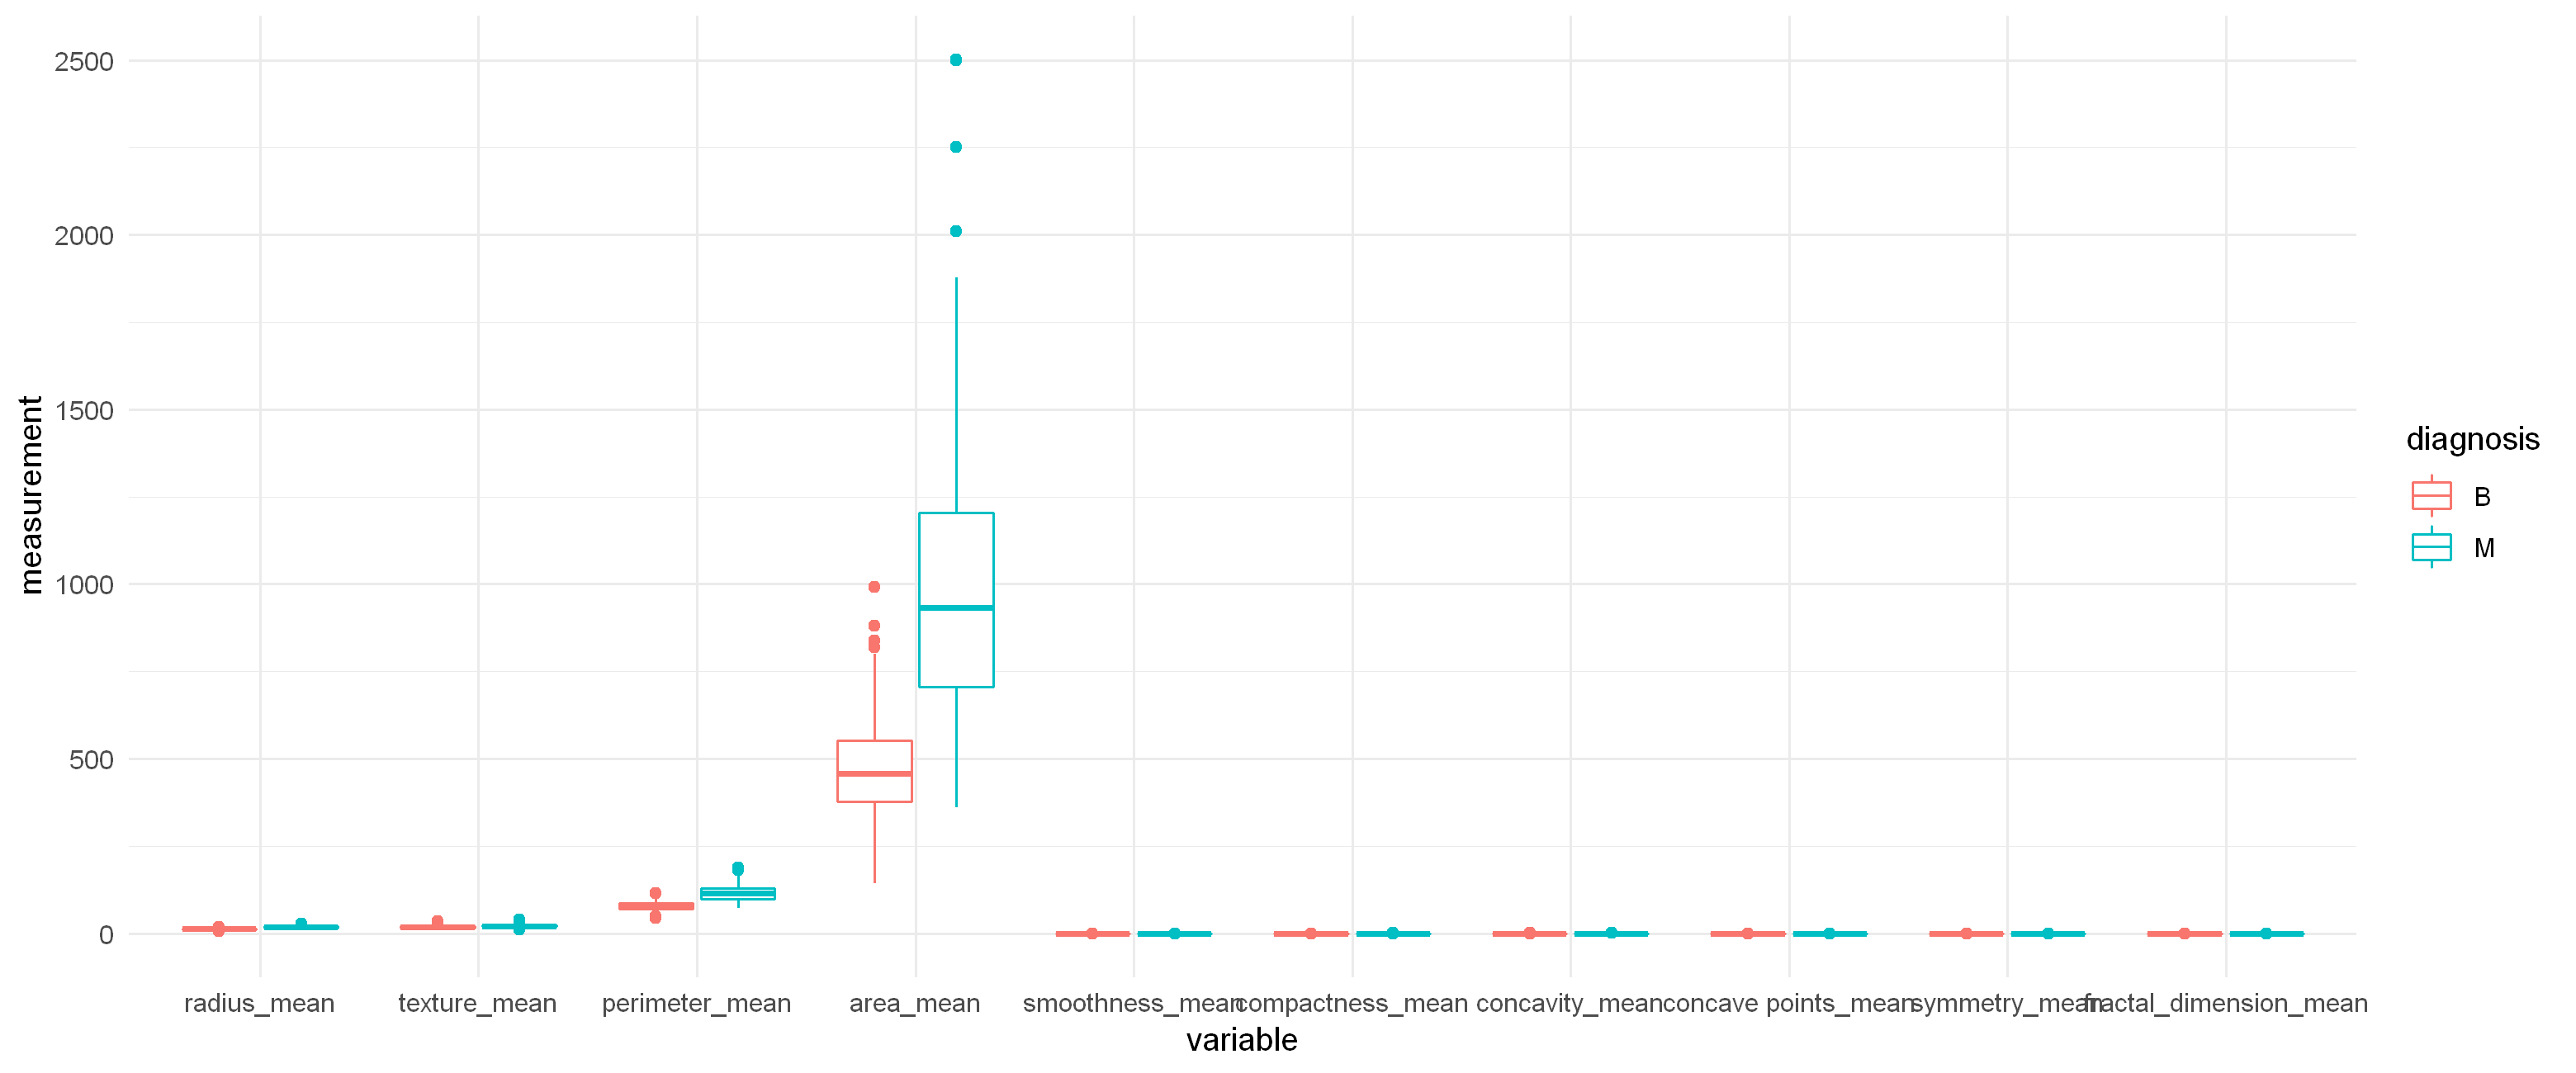

In [5]:
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res=260)

data_mean <- data_long %>% filter(grepl('_mean', variable))

ggplot(data_mean, aes(x = variable, y = measurement, color = diagnosis)) + 
    geom_boxplot() + 
    theme_minimal()

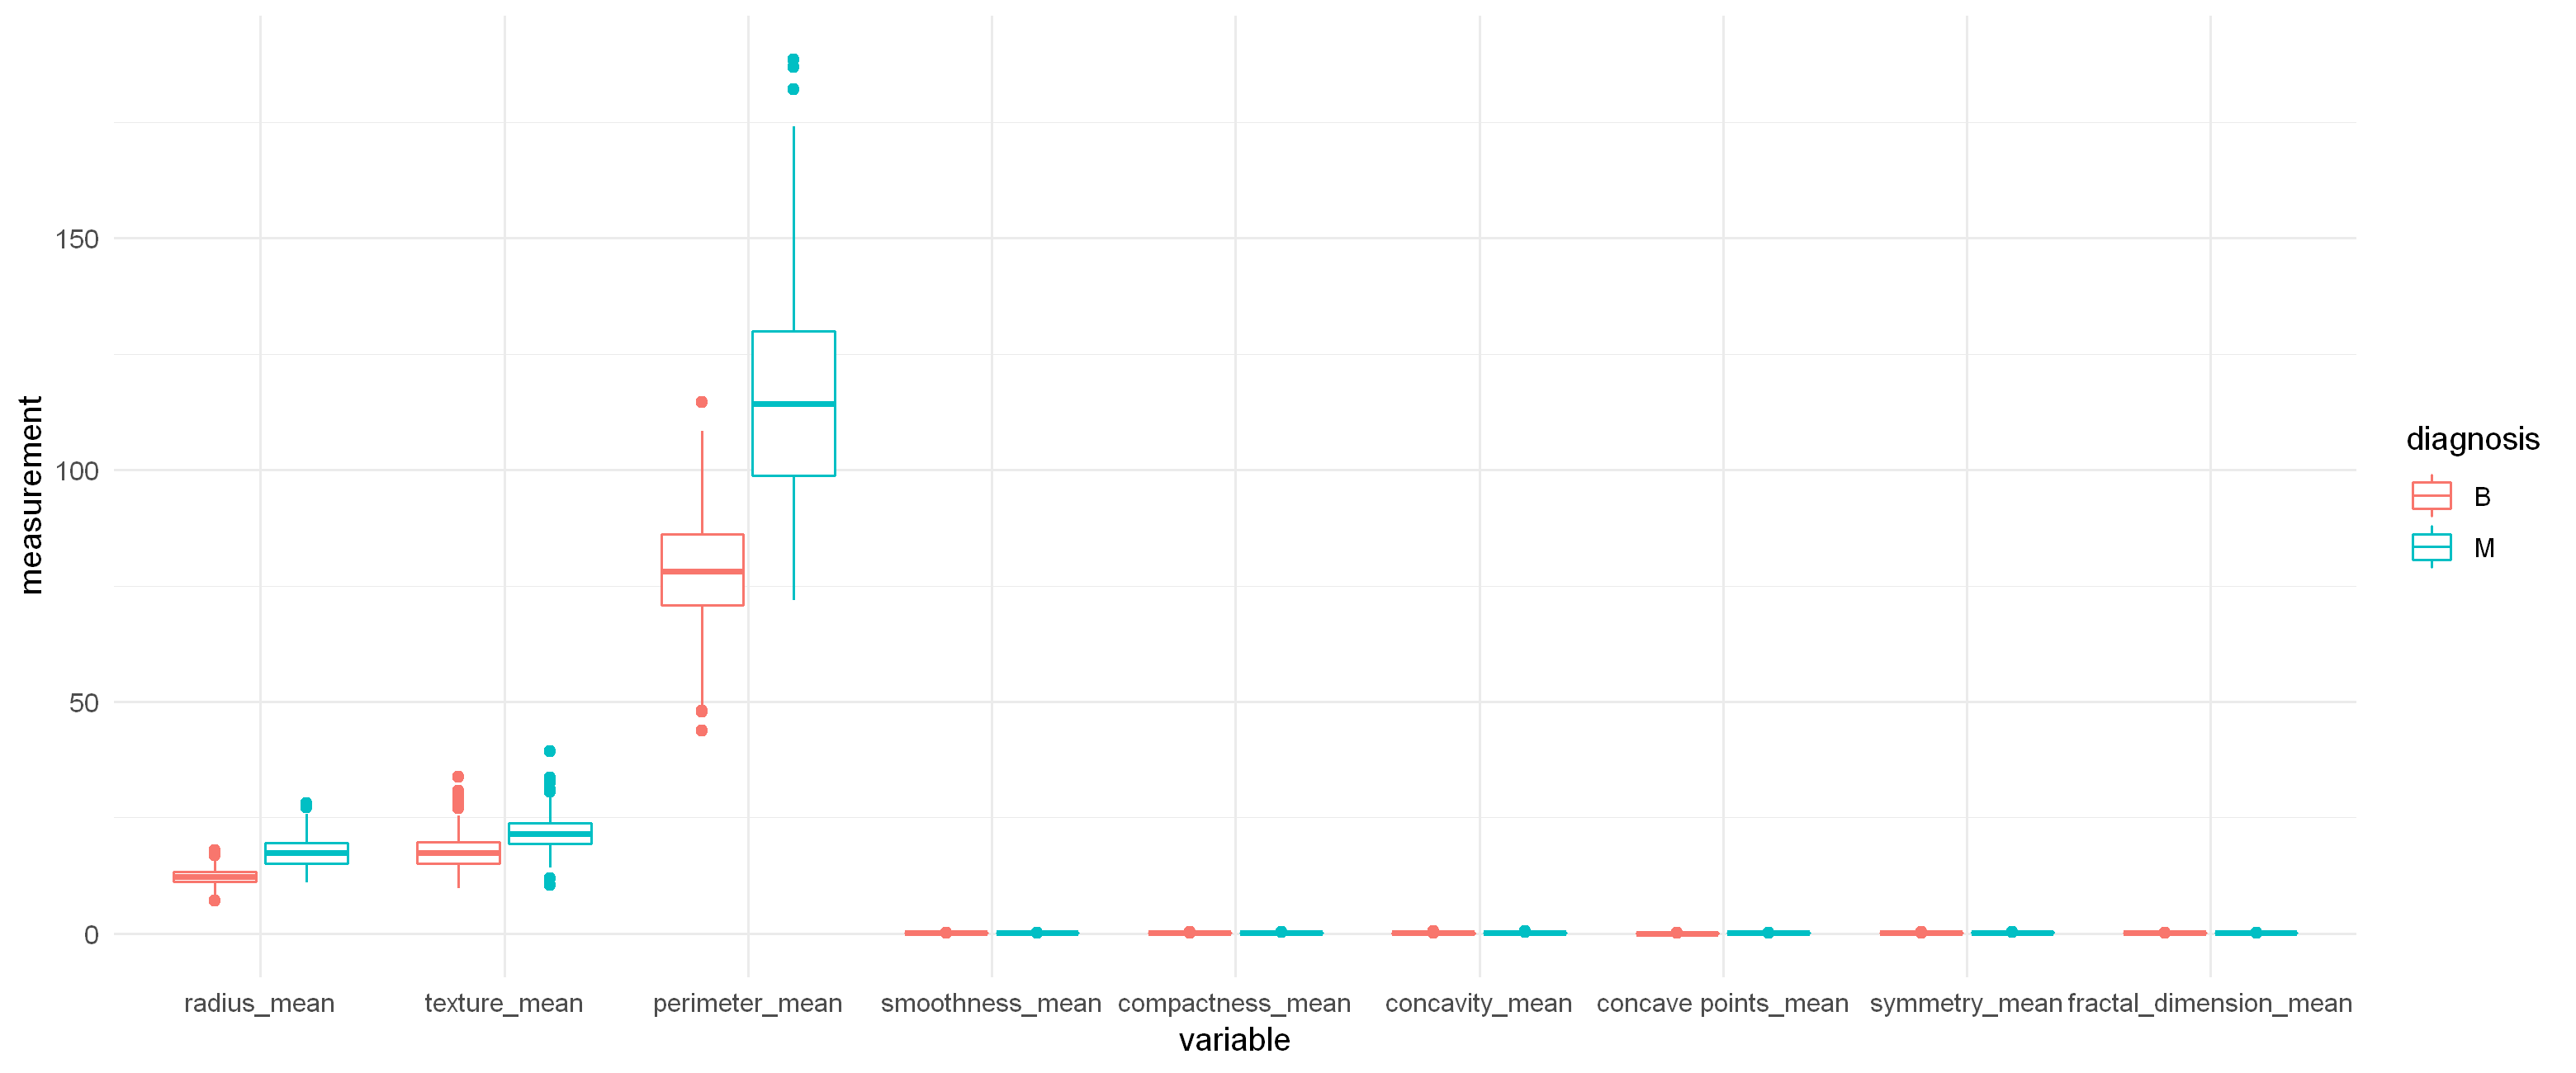

In [6]:
ggplot(data_mean %>% filter(variable != "area_mean"), aes(x = variable, y = measurement, color = diagnosis)) + 
    geom_boxplot() + 
    theme_minimal()

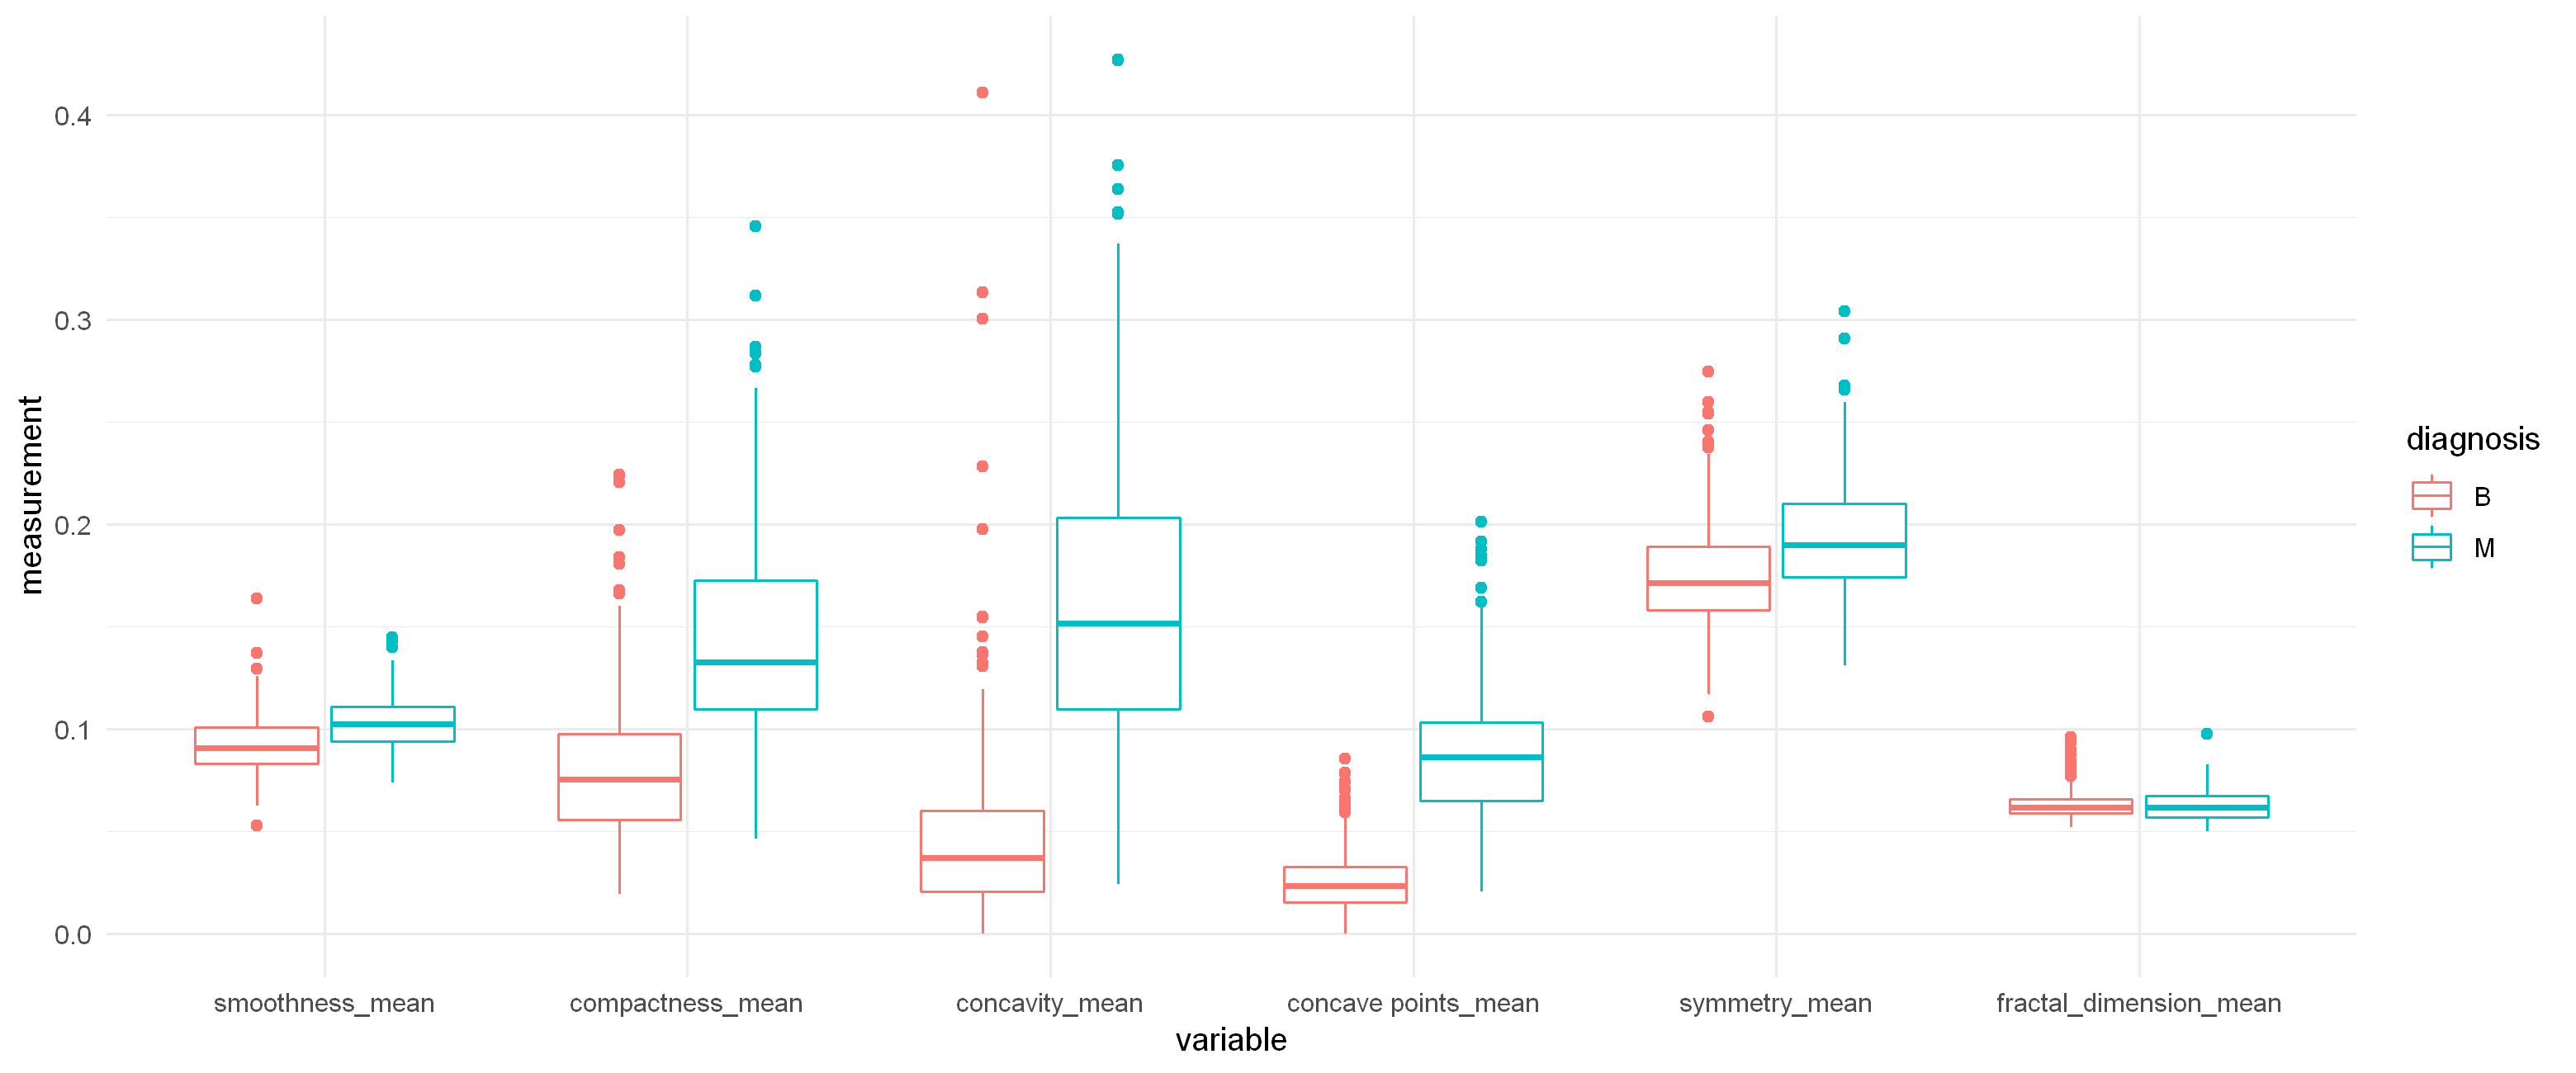

In [7]:
data_mean_filtered <- data_mean %>% 
    filter(!variable %in% c("area_mean", "perimeter_mean", "radius_mean", "texture_mean")) 

ggplot(data_mean_filtered, aes(x = variable, y = measurement, color = diagnosis)) + 
    geom_boxplot() + 
    theme_minimal()

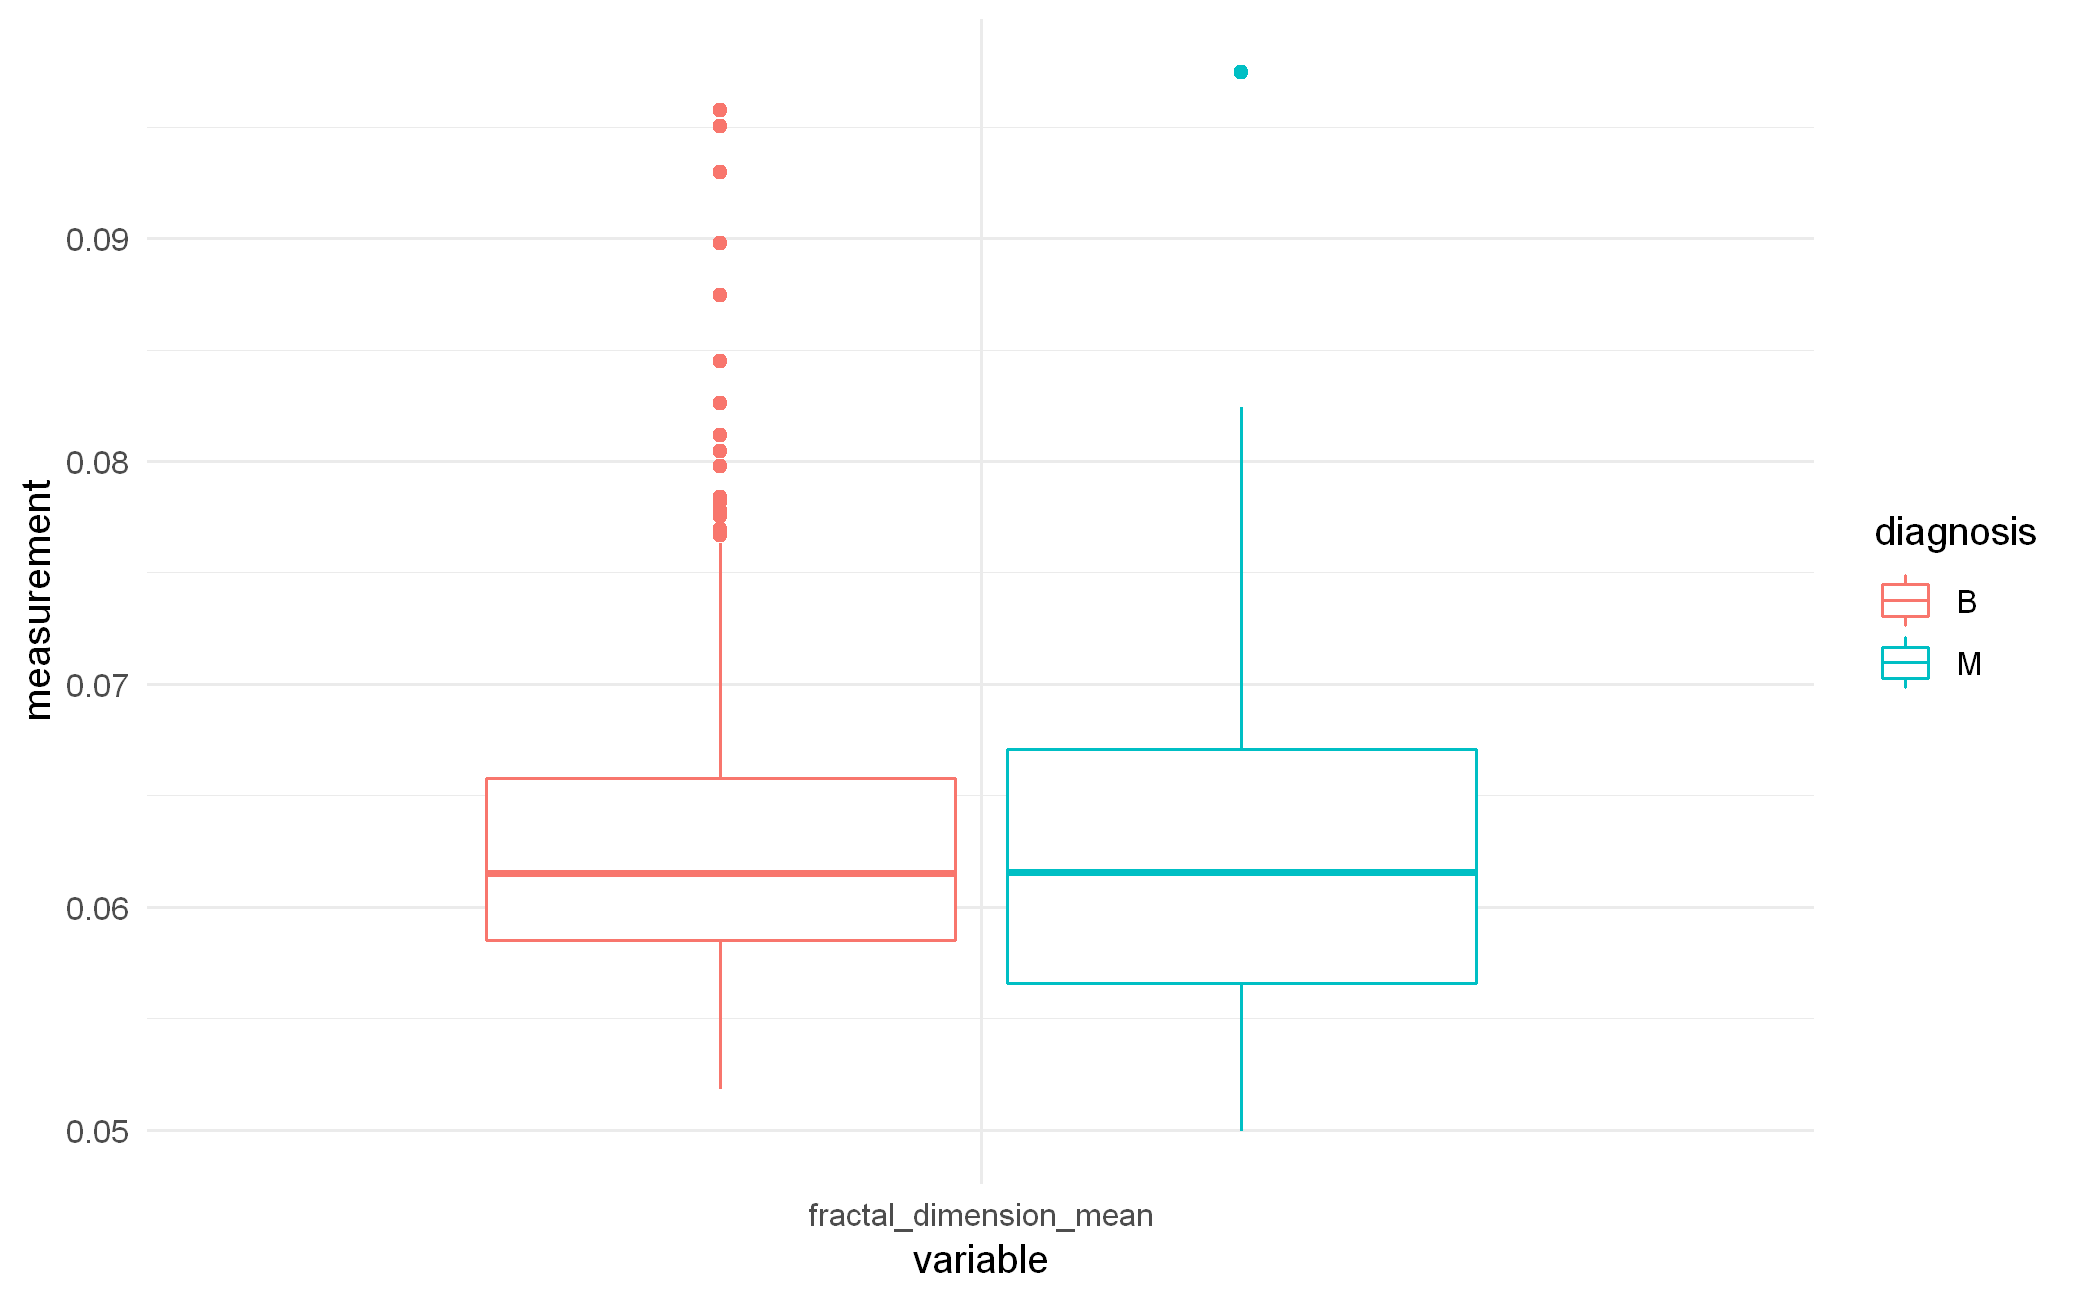

In [8]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=260)

data_long %>% 
    filter(variable == "fractal_dimension_mean") %>%
    ggplot(aes(x = variable, y = measurement, color = diagnosis)) + 
        geom_boxplot() + 
        theme_minimal()

# Pre-Process

## Finding Variables with High Correlations to Diagnosis

In [9]:
corr_data <- data %>%
    mutate(diagnosis = ifelse(diagnosis == "M", 1, 0))

mean_corr <- corr_data %>%
    select(diagnosis, radius_mean:fractal_dimension_mean) %>%
    cor()

print(mean_corr[1,])

             diagnosis            radius_mean           texture_mean 
             1.0000000              0.7300285              0.4151853 
        perimeter_mean              area_mean        smoothness_mean 
             0.7426355              0.7089838              0.3585600 
      compactness_mean         concavity_mean    concave points_mean 
             0.5965337              0.6963597              0.7766138 
         symmetry_mean fractal_dimension_mean 
             0.3304986             -0.0128376 


In [10]:
se_corr <- corr_data %>%
    select(diagnosis, radius_se:fractal_dimension_se) %>%
    cor()

print(se_corr[1,])

           diagnosis            radius_se           texture_se 
         1.000000000          0.567133821         -0.008303333 
        perimeter_se              area_se        smoothness_se 
         0.556140703          0.548235940         -0.067016011 
      compactness_se         concavity_se    concave points_se 
         0.292999244          0.253729766          0.408042333 
         symmetry_se fractal_dimension_se 
        -0.006521756          0.077972417 


In [11]:
worst_corr <- corr_data %>%
    select(diagnosis, radius_worst:fractal_dimension_worst) %>%
    cor()

print(worst_corr[1,])

              diagnosis            radius_worst           texture_worst 
              1.0000000               0.7764538               0.4569028 
        perimeter_worst              area_worst        smoothness_worst 
              0.7829141               0.7338250               0.4214649 
      compactness_worst         concavity_worst    concave points_worst 
              0.5909982               0.6596102               0.7935660 
         symmetry_worst fractal_dimension_worst 
              0.4162943               0.3238722 


In [12]:
# selecting vars with high correlation
data_model <- data %>%
    select(diagnosis, radius_mean, perimeter_mean, area_mean, "concave points_mean", radius_worst, perimeter_worst,
           area_worst, "concave points_worst") %>%
    mutate(diagnosis = as.factor(diagnosis))

In [13]:
data_split <- initial_split(data_model)

In [14]:
data_split %>% training() %>% glimpse()

Rows: 426
Columns: 9
$ diagnosis              <fct> B, B, M, B, B, B, B, B, M, B, B, B, B, B, B, B,~
$ radius_mean            <dbl> 9.405, 9.000, 16.160, 12.720, 12.580, 13.110, 1~
$ perimeter_mean         <dbl> 59.60, 56.36, 106.20, 81.78, 79.83, 87.02, 71.3~
$ area_mean              <dbl> 271.2, 246.3, 809.8, 492.1, 489.0, 529.4, 390.0~
$ `concave points_mean`  <dbl> 0.012570, 0.003472, 0.056130, 0.019240, 0.00292~
$ radius_worst           <dbl> 10.850, 9.699, 19.470, 13.500, 13.500, 14.550, ~
$ perimeter_worst        <dbl> 68.73, 60.90, 129.70, 88.54, 85.56, 99.48, 82.0~
$ area_worst             <dbl> 359.4, 285.5, 1175.0, 553.7, 564.1, 639.3, 492.~
$ `concave points_worst` <dbl> 0.037700, 0.013890, 0.131200, 0.063430, 0.00877~


In [15]:
model_recipe <- training(data_split) %>%
    recipe(diagnosis ~.) %>%
    step_corr(all_predictors()) %>%
    step_center(all_predictors(), -all_outcomes()) %>%
    step_scale(all_predictors(), -all_outcomes()) %>%
    prep()

model_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 426 data points and no missing data.

Operations:

Correlation filter removed perimeter_mean, ... [trained]
Centering for area_worst, concave points_worst [trained]
Scaling for area_worst, concave points_worst [trained]

In [16]:
model_testing <- model_recipe %>%
    bake(testing(data_split)) 

glimpse(model_testing)

Rows: 143
Columns: 3
$ area_worst             <dbl> 1.2484425427, 0.4552330570, 0.4343591232, -0.44~
$ `concave points_worst` <dbl> 1.13478832, -0.25471147, 0.65452247, -0.6549825~
$ diagnosis              <fct> M, M, M, B, M, B, B, B, B, M, M, M, B, M, B, B,~


In [17]:
model_training <- juice(model_recipe)

glimpse(model_training)

Rows: 426
Columns: 3
$ area_worst             <dbl> -0.92001128, -1.04855993, 0.49872042, -0.582027~
$ `concave points_worst` <dbl> -1.17732743, -1.53135622, 0.21291580, -0.794750~
$ diagnosis              <fct> B, B, M, B, B, B, B, B, M, B, B, B, B, B, B, B,~


# Model Training - Random Forest

In [18]:
model_rf <-  rand_forest(trees = 100, mode = "classification") %>%
    set_engine("randomForest") %>%
    fit(diagnosis ~ ., data = model_training)

In [19]:
model_rf %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    glimpse()

Rows: 143
Columns: 4
$ .pred_class            <fct> M, M, M, B, M, B, B, B, B, M, M, B, B, M, B, B,~
$ area_worst             <dbl> 1.2484425427, 0.4552330570, 0.4343591232, -0.44~
$ `concave points_worst` <dbl> 1.13478832, -0.25471147, 0.65452247, -0.6549825~
$ diagnosis              <fct> M, M, M, B, M, B, B, B, B, M, M, M, B, M, B, B,~


# Model Validation - Random Forest

In [20]:
model_rf %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    metrics(truth = diagnosis, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9160839
kap,binary,0.8138829


In [21]:
model_probs <- model_rf %>%
    predict(model_testing, type = "prob") %>%
    bind_cols(model_testing)

glimpse(model_probs)

Rows: 143
Columns: 5
$ .pred_B                <dbl> 0.00, 0.29, 0.00, 0.95, 0.01, 1.00, 1.00, 0.74,~
$ .pred_M                <dbl> 1.00, 0.71, 1.00, 0.05, 0.99, 0.00, 0.00, 0.26,~
$ area_worst             <dbl> 1.2484425427, 0.4552330570, 0.4343591232, -0.44~
$ `concave points_worst` <dbl> 1.13478832, -0.25471147, 0.65452247, -0.6549825~
$ diagnosis              <fct> M, M, M, B, M, B, B, B, B, M, M, M, B, M, B, B,~


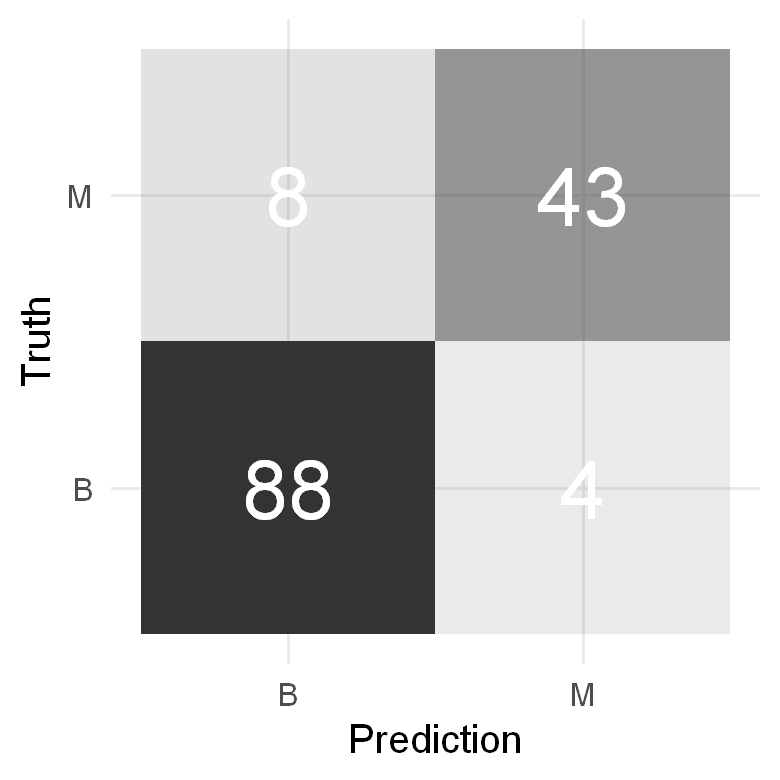

In [22]:
conf <- model_rf %>% 
    predict(model_testing) %>%
    bind_cols(model_testing %>% select(diagnosis)) %>%
    conf_mat(diagnosis, .pred_class)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)
conf %>%
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

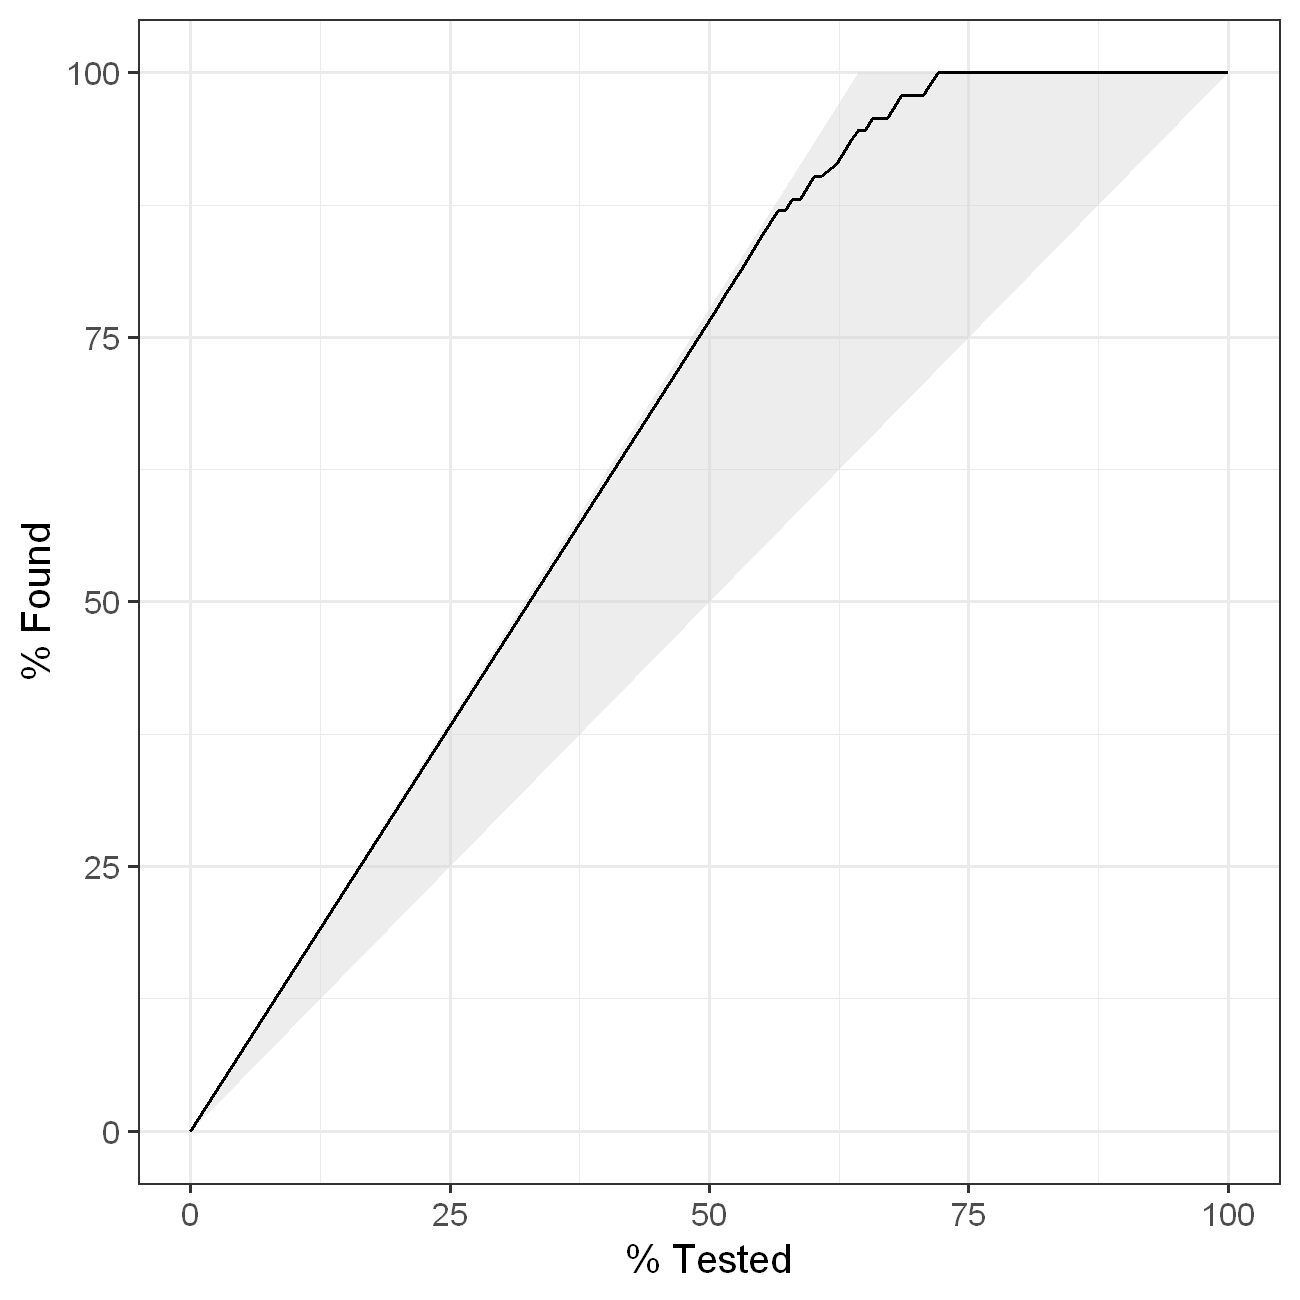

In [23]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
model_probs %>%
    gain_curve(diagnosis, .pred_B) %>%
    autoplot()

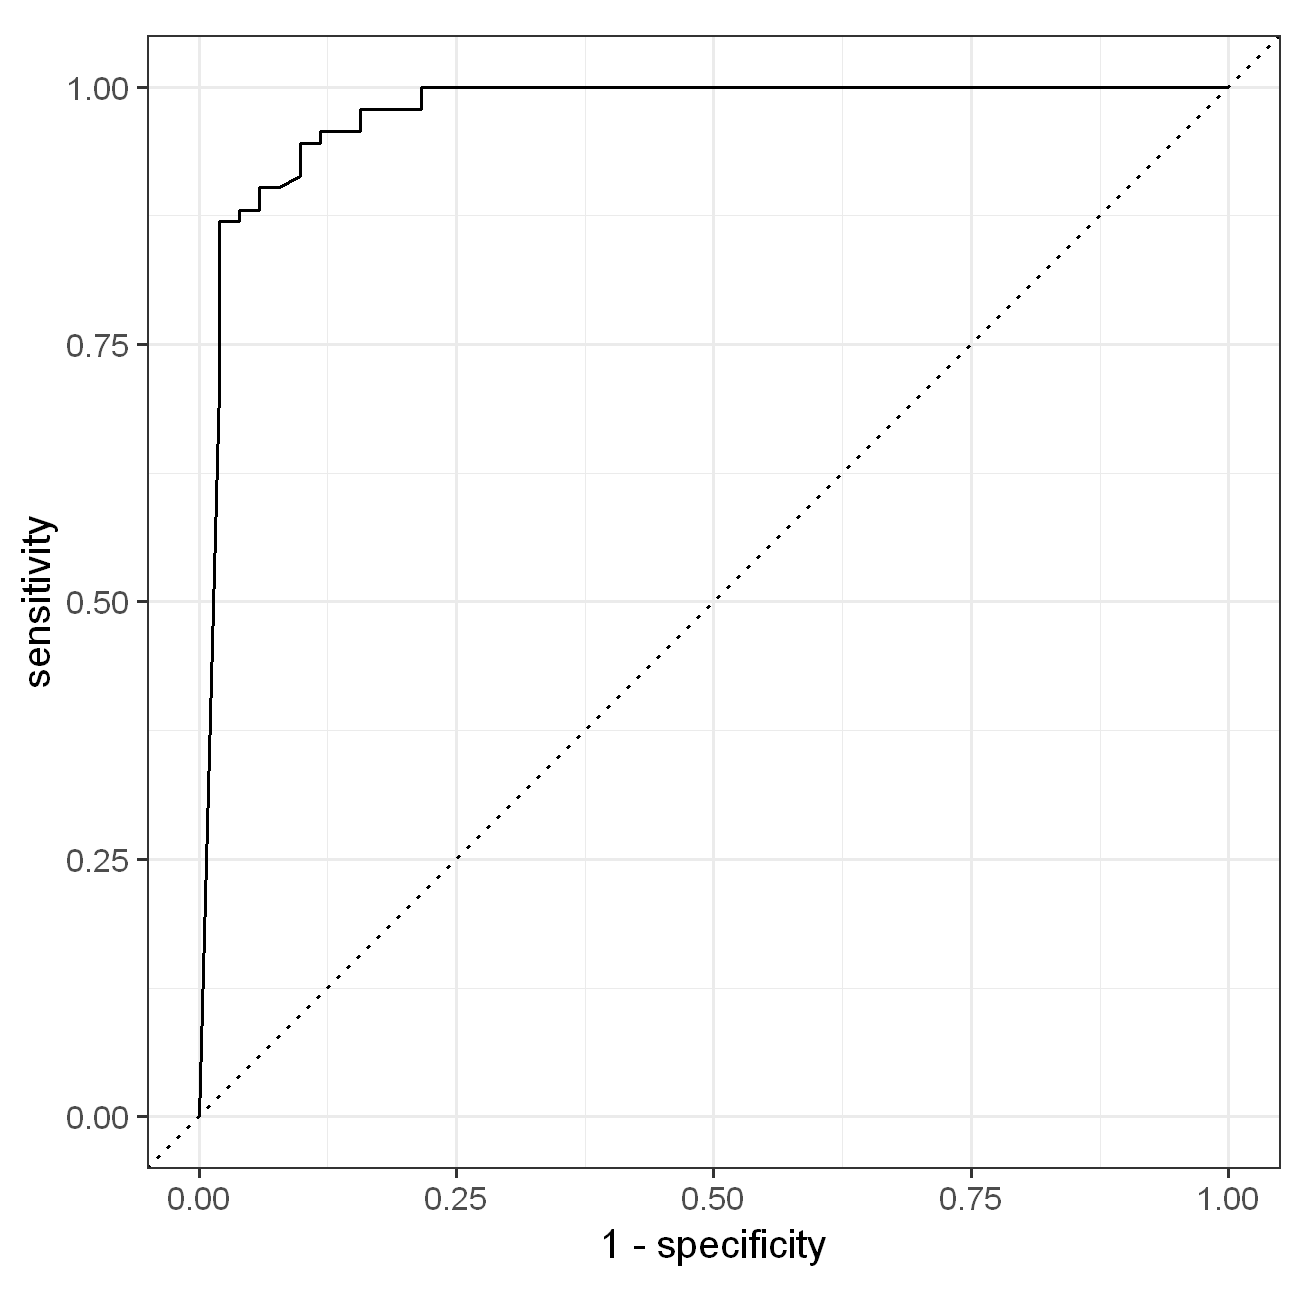

In [24]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
model_probs %>%
    roc_curve(diagnosis, .pred_B) %>%
    autoplot()

In [25]:
predict(model_rf, model_testing, type = "prob") %>%
    bind_cols(predict(model_rf, model_testing)) %>%
    bind_cols(select(model_testing, diagnosis)) %>%
    metrics(diagnosis, .pred_M, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.91608392
kap,binary,0.81388286
mn_log_loss,binary,23.63435668
roc_auc,binary,0.02536232


# Model Training - K-Nearest Neighbors

In [26]:
model_knn <- nearest_neighbor(mode = "classification", 
                              neighbors = 5, 
                              weight_func = "gaussian", 
                              dist_power = 2) %>%
    set_engine("kknn") %>%
    fit(diagnosis ~ ., data = model_training)

In [27]:
model_knn %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    glimpse()

Rows: 143
Columns: 4
$ .pred_class            <fct> M, M, M, B, M, B, B, B, B, M, M, B, B, M, B, B,~
$ area_worst             <dbl> 1.2484425427, 0.4552330570, 0.4343591232, -0.44~
$ `concave points_worst` <dbl> 1.13478832, -0.25471147, 0.65452247, -0.6549825~
$ diagnosis              <fct> M, M, M, B, M, B, B, B, B, M, M, M, B, M, B, B,~


# Model Validation - K-Nearest Neighbors

In [28]:
model_knn %>%
    predict(model_testing) %>%
    bind_cols(model_testing) %>%
    metrics(truth = diagnosis, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9370629
kap,binary,0.8597886


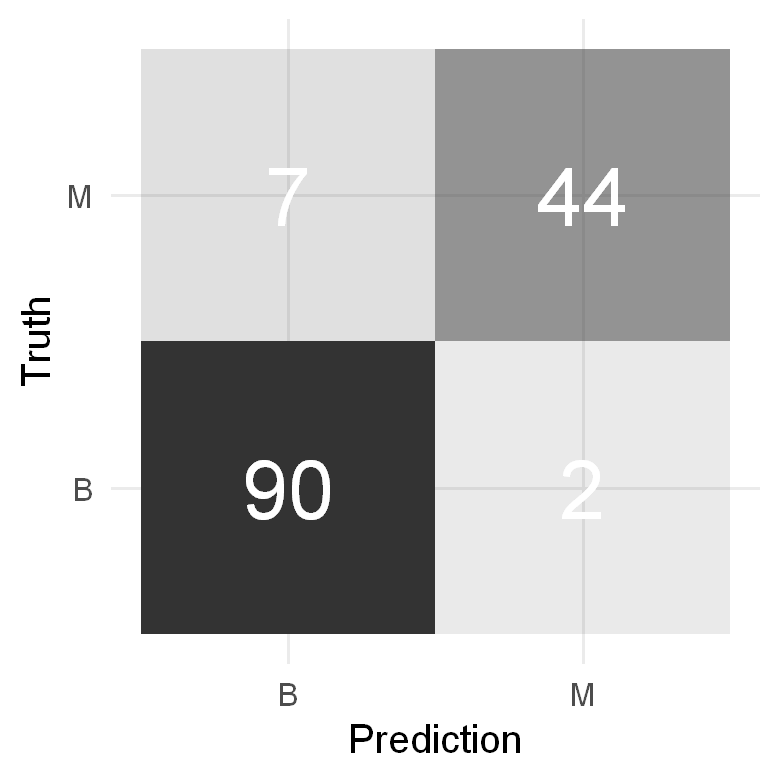

In [29]:
conf_knn <- model_knn %>% 
    predict(model_testing) %>%
    bind_cols(model_testing %>% select(diagnosis)) %>%
    conf_mat(diagnosis, .pred_class)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)
conf_knn %>%
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

# Alternative Workflow

In [30]:
data_train <- training(data_split)
data_test <- testing(data_split)

data_bootstrap <- bootstraps(data_train)

In [31]:
# specifying models, comparison of above two plus logistic regression
model_alt_glm <- logistic_reg() %>%
    set_engine("glm")

model_alt_rf <- rand_forest(trees = 100, mode = "classification") %>%
    set_engine("randomForest")

model_alt_knn <- nearest_neighbor(mode = "classification", 
                                  neighbors = 5, 
                                  weight_func = "gaussian", 
                                  dist_power = 2) %>%
    set_engine("kknn")

In [32]:
diagnosis_workflow <- workflow() %>%
    add_formula(diagnosis ~ .)

In [33]:
glm_results <- diagnosis_workflow %>%
    add_model(model_alt_glm) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

rf_results <- diagnosis_workflow %>%
    add_model(model_alt_rf) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

knn_results <- diagnosis_workflow %>%
    add_model(model_alt_knn) %>%
    fit_resamples(resamples = data_bootstrap, control = control_resamples(save_pred = TRUE))

! Bootstrap01: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap02: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap03: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap04: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap05: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap06: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap07: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap08: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap09: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap11: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...

! Bootstrap12: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numeri

In [34]:
collect_metrics(glm_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9484877,25,0.002858832,Preprocessor1_Model1
roc_auc,binary,0.9870268,25,0.001449726,Preprocessor1_Model1


In [35]:
collect_metrics(rf_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9459462,25,0.002593212,Preprocessor1_Model1
roc_auc,binary,0.9844032,25,0.001179205,Preprocessor1_Model1


In [36]:
collect_metrics(knn_results)

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.9364820,25,0.003346847,Preprocessor1_Model1
roc_auc,binary,0.9684616,25,0.003230477,Preprocessor1_Model1


In [37]:
results <- collect_metrics(glm_results) %>%
    mutate(model = "glm") %>%
    bind_rows(collect_metrics(rf_results) %>% mutate(model = "rf")) %>%
    bind_rows(collect_metrics(knn_results) %>% mutate(model = "knn"))

results

.metric,.estimator,mean,n,std_err,.config,model
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>
accuracy,binary,0.9484877,25,0.002858832,Preprocessor1_Model1,glm
roc_auc,binary,0.9870268,25,0.001449726,Preprocessor1_Model1,glm
accuracy,binary,0.9459462,25,0.002593212,Preprocessor1_Model1,rf
roc_auc,binary,0.9844032,25,0.001179205,Preprocessor1_Model1,rf
accuracy,binary,0.9364820,25,0.003346847,Preprocessor1_Model1,knn
roc_auc,binary,0.9684616,25,0.003230477,Preprocessor1_Model1,knn


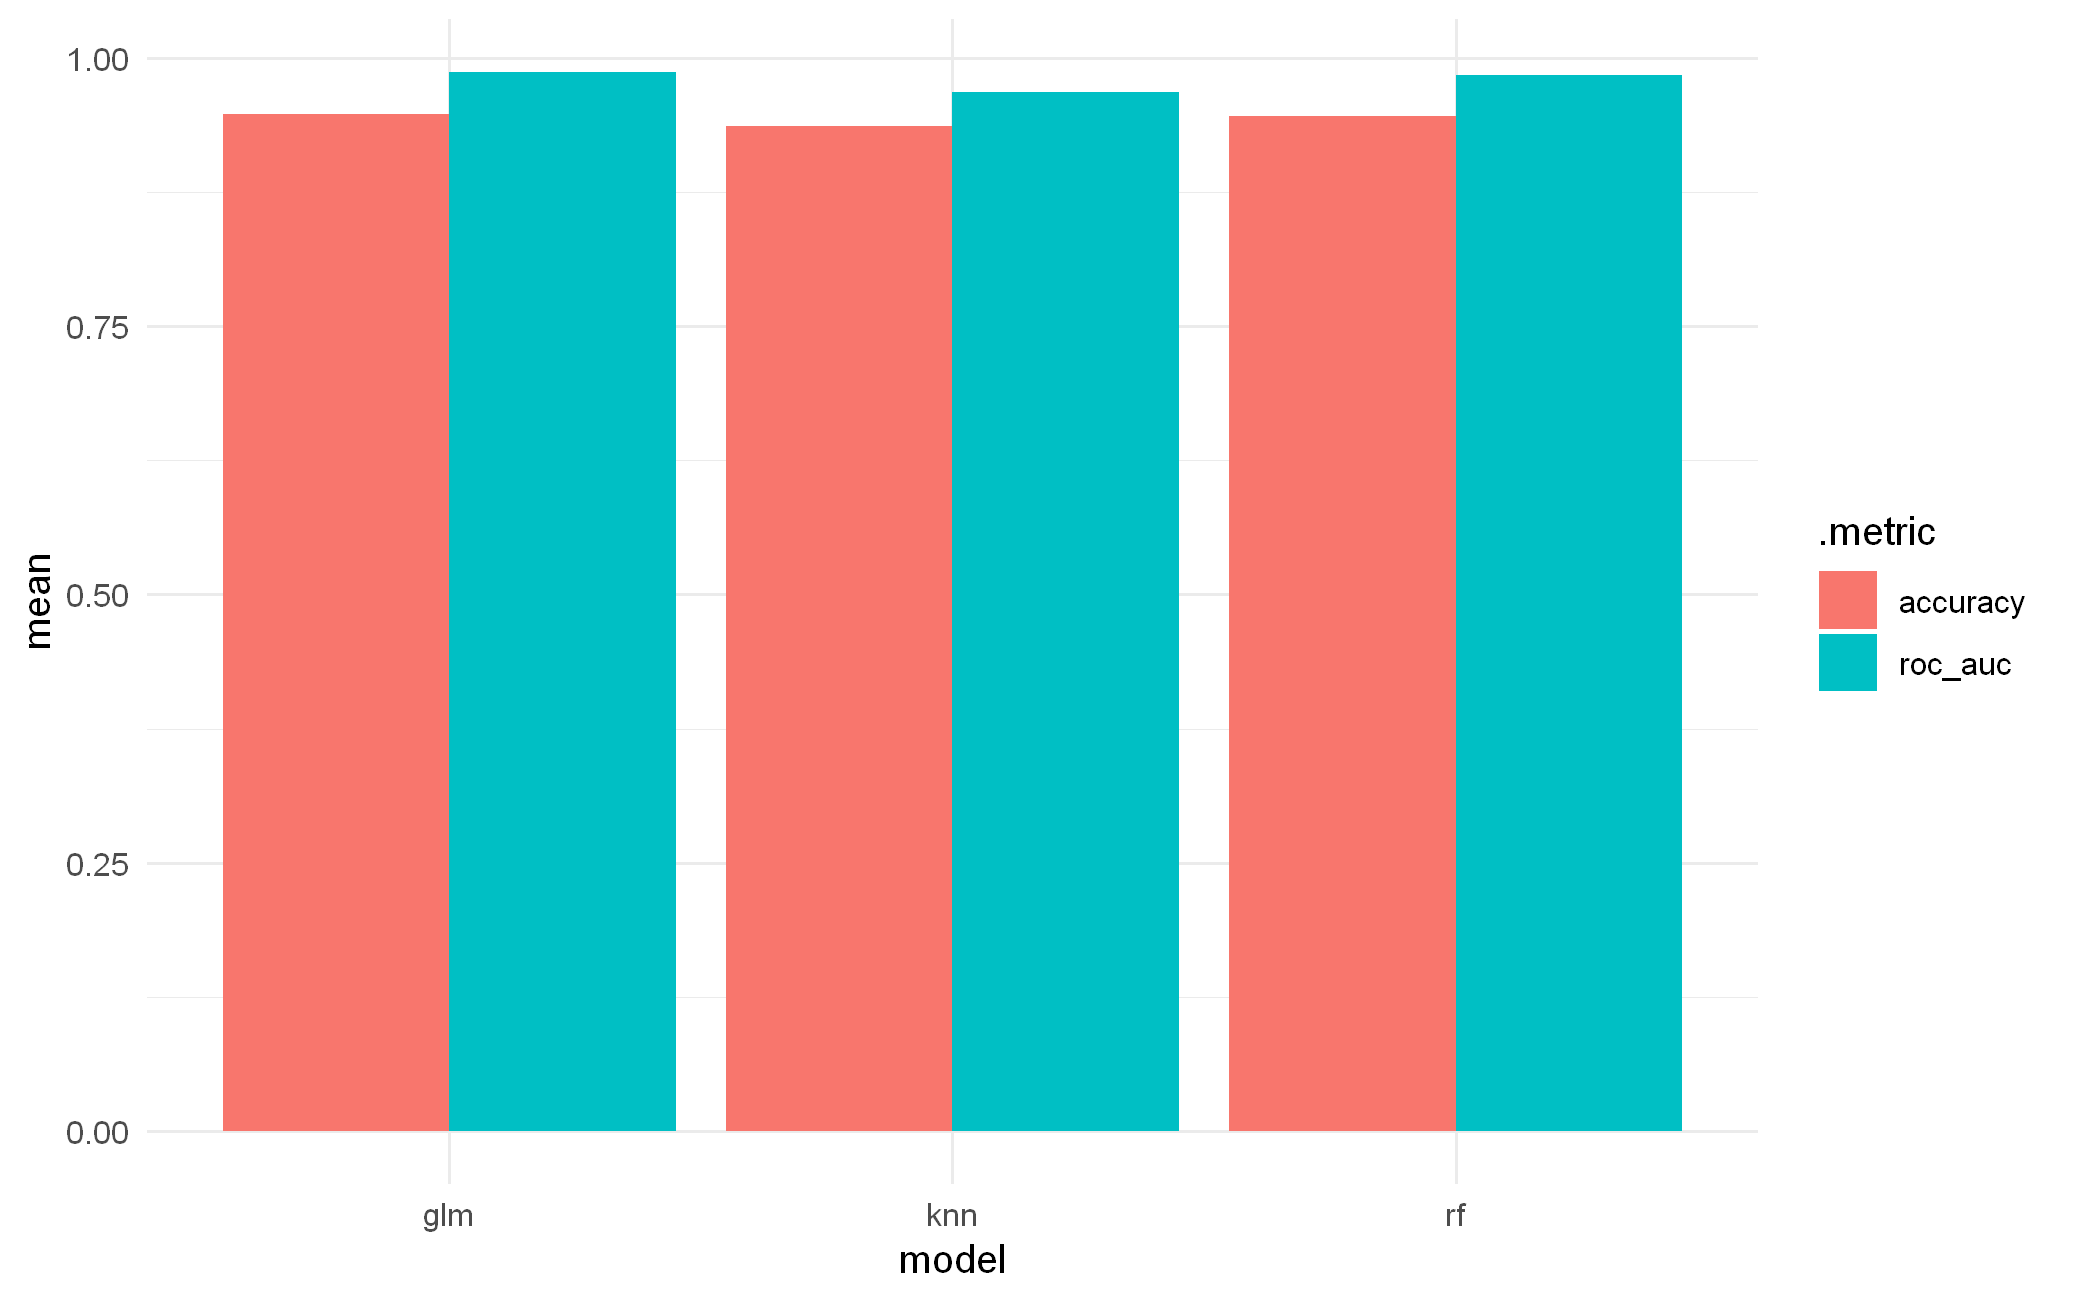

In [45]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res=260)
ggplot(results, aes(model, mean, fill = .metric)) + 
    geom_col(position = "dodge") + 
    theme_minimal()

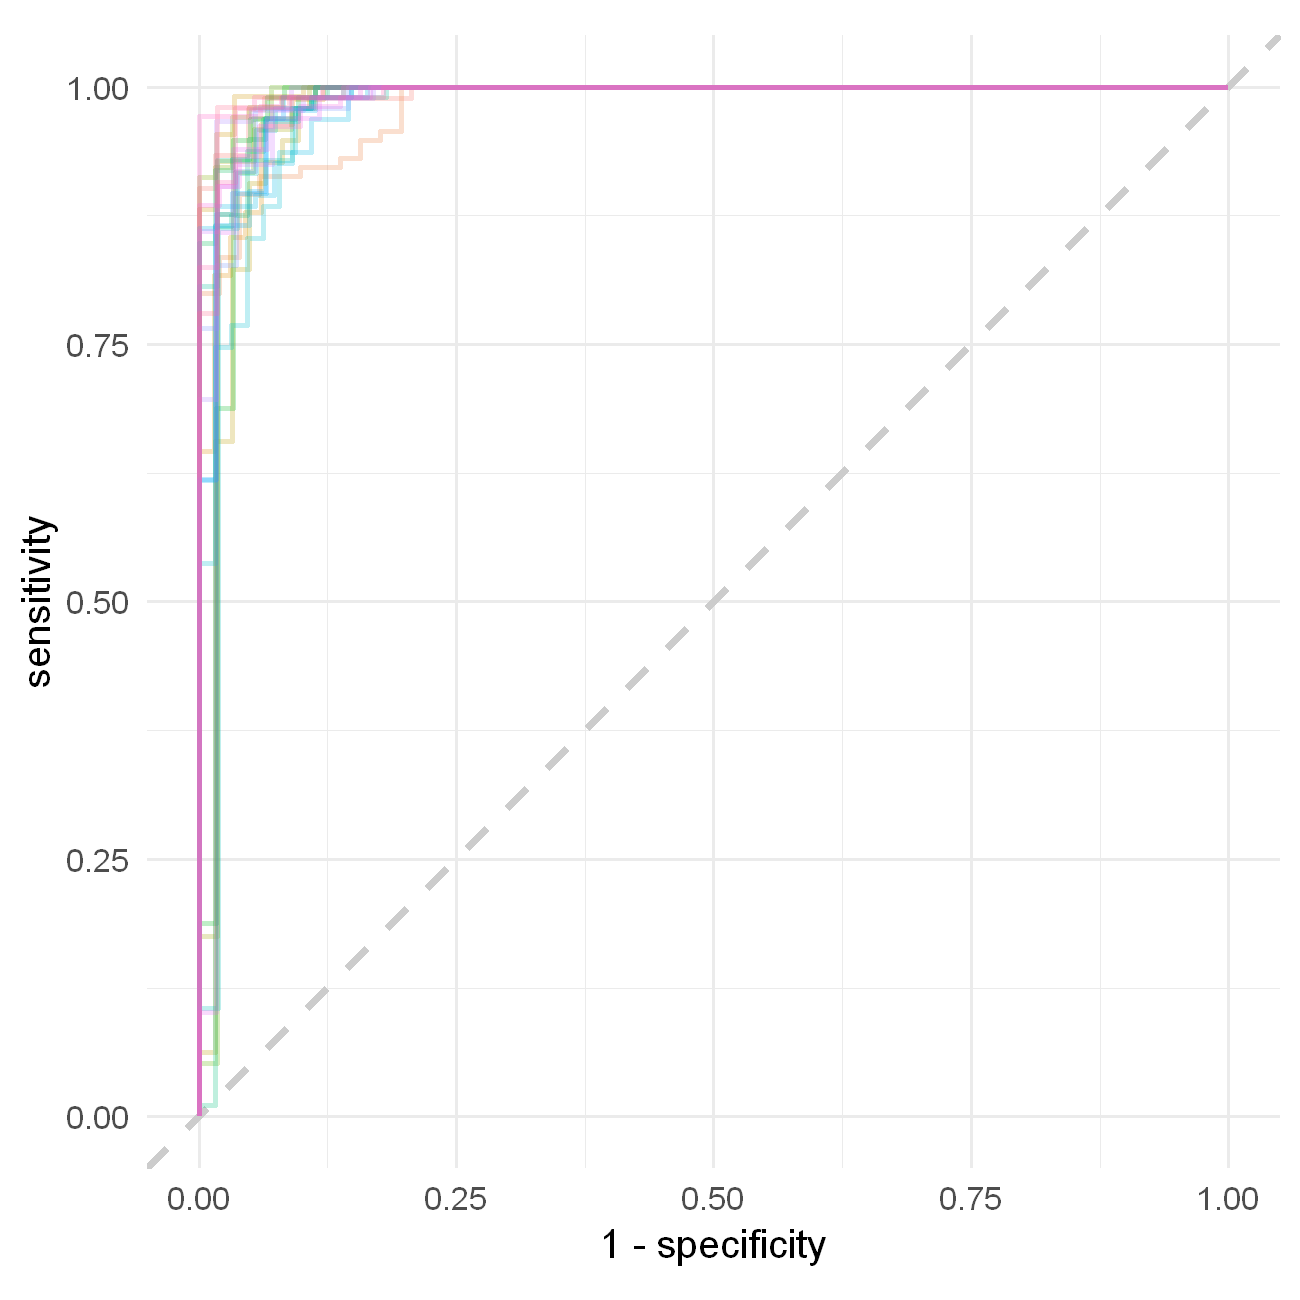

In [39]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=260)
glm_results %>%
    collect_predictions() %>%
    group_by(id) %>%
    roc_curve(diagnosis, .pred_B) %>%
    ggplot(aes(1 - specificity, sensitivity, color = id)) + 
        geom_abline(lty = 2, color = "gray80", size = 1) + 
        geom_path(show.legend = FALSE, alpha = 0.25, size = 0.75) + 
        coord_equal() + 
        theme_minimal()

In [40]:
diagnosis_final_model <- diagnosis_workflow %>%
    add_model(model_alt_glm) %>%
    last_fit(data_split)

! train/test split: preprocessor 1/1, model 1/1: glm.fit: fitted probabilities numerically 0...



In [41]:
collect_metrics(diagnosis_final_model)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.9720280,Preprocessor1_Model1
roc_auc,binary,0.9936061,Preprocessor1_Model1


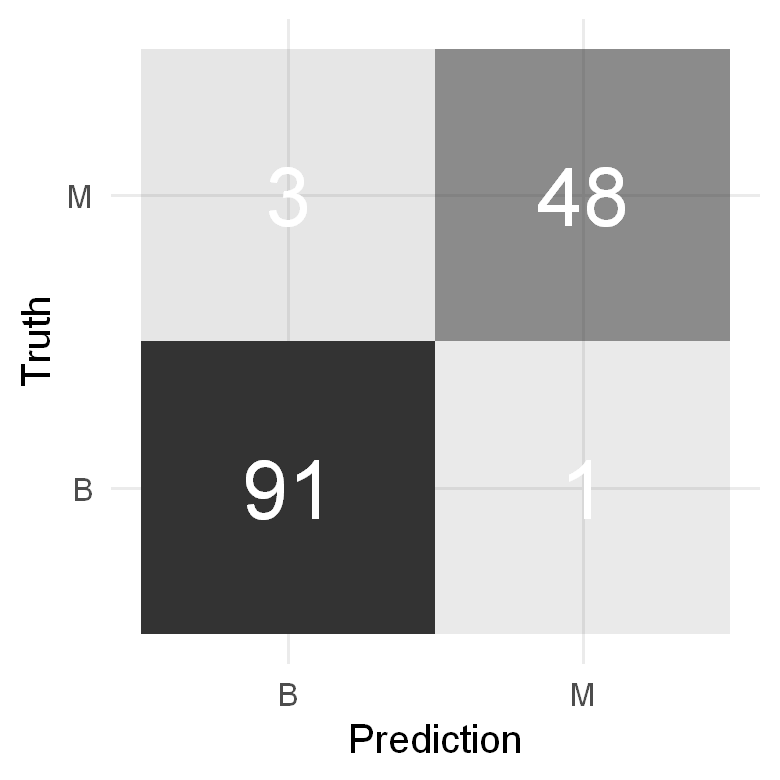

In [42]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=260)

collect_predictions(diagnosis_final_model) %>% 
    conf_mat(diagnosis, .pred_class) %>% 
    pluck(1) %>%
    as_tibble() %>%
    ggplot(aes(Prediction, Truth, alpha = n)) +
    geom_tile(show.legend = FALSE) +
    geom_text(aes(label = n), colour = "white", alpha = 1, size = 8) + 
    theme_minimal()

In [43]:
diagnosis_final_model$.workflow[[1]] %>%
    tidy(exponentiate = TRUE) %>%
    arrange(estimate)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
radius_mean,8.369943e-02,4.30001642,-0.57686363,0.56403158
perimeter_mean,9.811657e-01,0.49625973,-0.03831442,0.96943699
area_worst,1.013838e+00,0.01633756,0.84117596,0.40024937
area_mean,1.015255e+00,0.02656985,0.56979909,0.56881397
perimeter_worst,1.072725e+00,0.11761734,0.59686818,0.55059539
radius_worst,1.138674e+00,1.66454119,0.07801828,0.93781351
(Intercept),1.940331e+00,9.84452417,0.06733273,0.94631682
`\`concave points_worst\``,2.773601e+08,14.10079359,1.37870447,0.16798589
`\`concave points_mean\``,3.766371e+28,32.26540711,2.03928914,0.04142118
